In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay, plot_roc_curve, fbeta_score, make_scorer

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB

In [2]:
X_train = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\X_train_bad_d')
X_test = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\X_test_bad_d')
y_train = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\y_train_bad_d')
y_test = pd.read_csv(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim\y_test_bad_d')

In [3]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.ravel()
y_test= y_test.values.ravel()

# To Do

Add each metric to a list so it can be graphed

implement pipeline for convinience 

use over and under sampling with SMOTE

create graphs for metrics to justify model selection



In [4]:
def classify(model, X_train=X_train, y_train=y_train, X_test=X_test ):
    '''Takes in model, X_train, X_test, y_train
    returns tuple of (fit model, y_pred, predict_proba[:,1])'''
    
    m = model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    prob = model.predict_proba(X_test)[:,1]
    
    return (m, pred, prob)


fb_scorer = make_scorer(fbeta_score, beta=0.3)

def model_cv(model, X=X_train, y=y_train, cv=5, scoring=fb_scorer, f1=True, stats=False):
    '''takes the model, X_train, y_train, cv(=5), scoring(='roc_auc')
    returns mean roc_auc and mean of input socre default f1, prints array, mean, std of scores scores'''
    
    scores = cross_val_score(model, X, y, cv=cv, 
                             scoring='roc_auc', n_jobs=-1)
    
    
    scores1 = cross_val_score(model, X, y, cv=cv, 
                             scoring=scoring, n_jobs=-1)
    
    if stats:
        print(str(model))
        print(scores)
        print('Mean roc-auc:', scores.mean())
        print('STD roc-auc', scores.std())
    
    return (scores.mean(), scores1.mean())

def model_cv1(model, X=X_train, y=y_train, cv=5, scoring=fb_scorer):
    '''takes the model, X_train, y_train, cv(=5), scoring(='roc_auc')
    returns mean roc_auc and mean of input socre default f1, prints array, mean, std of scores scores'''
    
    
    scores = cross_val_score(model, X, y, cv=cv, 
                             scoring=scoring, n_jobs=-1)    
    
    return scores.mean()
    
def find_threshold(probs, y_test=y_test):
    '''takes predict_proba[:,1] for certain model, y_test is set because imonly doing this for the one y_test
    uses Youdens J statistic
    prints the threshold
    returns new predictions given the threshold'''
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    gmeans = tpr - fpr
    
    thresh = thresholds[np.argmax(gmeans)]
    
    print('The threshold is', thresh)
    return (probs >= thresh).astype(int)


In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

smo = SMOTE(sampling_strategy=0.1) # 'over' in pipeline
bor = BorderlineSMOTE(sampling_strategy=0.1) # 'over' in pipeline
ada = ADASYN(sampling_strategy=0.1) # 'over'
svm = SVMSMOTE(sampling_strategy=0.1)

under = RandomUnderSampler(sampling_strategy=0.5)

In [6]:
cv = StratifiedKFold(n_splits=5)
xcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2)

## Baseline Modeling

In [36]:
# ONE CLASS SVM: FIT TO ONLY NEGATIVE CLASS IN TRAINING VAUES, USE BOTH CLASSES FOR TEST.  NO RESAMPLING

# ISOLATED FOREST: NORMAL TEST AND FIT, NO RESAMPLING

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB

classifiers = ['Log Reg',
               'KNN', 
               'Random Forest', 
               'Gradient Boost',
              ] # 'ComplementNB'

scores_roc = []
smo_scores_roc = []
bor_scores_roc = []
ada_scores_roc = []
svm_scores_roc = []


scores_f1 = []
smo_scores_f1 = []
bor_scores_f1 = []
ada_scores_f1 = []
svm_scores_f1 = []

lr = LogisticRegression(random_state=2)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=2)
gb = GradientBoostingClassifier(random_state=2)


models = [lr, knn, rf, gb]

for m in models:
    steps= [('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    scores_roc.append(round(roc,3))
    scores_f1.append(round(f1,3))
    
for m in models:
    steps= [('over', smo), ('under', under), ('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    smo_scores_roc.append(round(roc,3))
    smo_scores_f1.append(round(f1,3))
    
for m in models:
    steps= [('over', bor), ('under', under), ('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    bor_scores_roc.append(round(roc,3))
    bor_scores_f1.append(round(f1,3))
    
for m in models:
    steps= [('over', ada), ('under', under), ('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    ada_scores_roc.append(round(roc,3))
    ada_scores_f1.append(round(f1,3))
    
for m in models:
    steps= [('over', svm), ('under', under), ('model', m)]
    pl = Pipeline(steps=steps)
    roc, f1 = model_cv(pl, cv=xcv)
    svm_scores_roc.append(round(roc,3))
    svm_scores_f1.append(round(f1,3))
    
roc_auc_cv = pd.DataFrame(list(zip(scores_roc, 
                                   smo_scores_roc,
                                   bor_scores_roc,
                                   ada_scores_roc,
                                   svm_scores_roc)),
                          index=classifiers,
                         columns=['ROC-AUC', 'SMOTE ROC-AUC',
                                 'Borderline ROC_AUC', 'ADASYN ROC-AUC', 'SVM SMOTE ROC-AUC'])

f1_cv = pd.DataFrame(list(zip(scores_f1, 
                              smo_scores_f1,
                              bor_scores_f1,
                              ada_scores_f1,
                              svm_scores_f1)),
                          index=classifiers,
                         columns=['F1', 'SMOTE F1',
                                 'Borderline F1', 'ADASYN F1', 'SVM SMOTE F1'])

## ADD TEST SCORES TO ALL INITAL SCORES?

In [70]:
roc_auc_cv

,ROC-AUC,SMOTE ROC-AUC,Borderline ROC_AUC,ADASYN ROC-AUC,SVM SMOTE ROC-AUC
Log Reg,0.791,0.789,0.779,0.789,0.782
KNN,0.562,0.662,0.661,0.665,0.683
Random Forest,0.693,0.737,0.743,0.734,0.752
Gradient Boost,0.769,0.777,0.771,0.775,0.768


In [71]:
f1_cv # CURRENTLY F BETA

,F1,SMOTE F1,Borderline F1,ADASYN F1,SVM SMOTE F1
Log Reg,0.000,0.046,0.047,0.046,0.047
KNN,0.000,0.034,0.048,0.035,0.043
Random Forest,0.000,0.062,0.073,0.059,0.064
Gradient Boost,0.012,0.054,0.047,0.048,0.046


<AxesSubplot:>

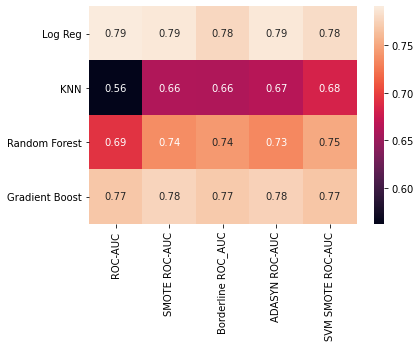

In [72]:
import seaborn as sns

sns.heatmap(roc_auc_cv, annot=True)

<AxesSubplot:>

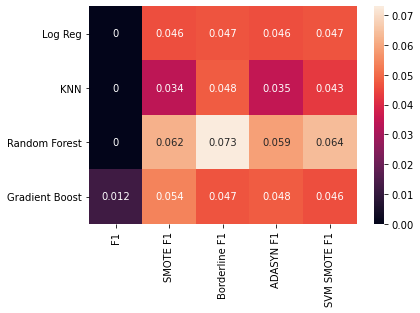

In [73]:
sns.heatmap(f1_cv, annot=True)

## Next Steps:

Pick two models to tune

make graphs / confusion matrixes

### Models:

##### Random Forest Borderline SMOTE
- Best fbeta value by far

##### Gradient Boosting SMOTE
- Best fbeta outside of random forest, and good roc auc

##### Logistic Regression SVMSMOTE
- not anymore
- Best overall score

##  Gridsearch

In [7]:
def gs_tuning(model, params, X=X_train, y=y_train, scoring=fb_scorer, n_jobs=-1, cv=xcv):
    
    m = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=scoring,
                    n_jobs=n_jobs,
                    cv=cv)
    
    m.fit(X_train,y_train)
    
    #pred = m.predict_proba(X_test)[:,1]
    
    print(m.best_params_,)
    print('Train score:', m.best_score_)
    print('Test score:', m.score(X_test, y_test))#roc_auc_score(y_test, pred)
    print(m.best_estimator_)
    

##### Random Forest BorderlineSMOTE

In [8]:
def gs_rand(model, params, X=X_train, y=y_train, scoring=fb_scorer, n_jobs=-1, cv=xcv):
    
    m = RandomizedSearchCV(model,
                           params,
                           scoring=scoring,
                           n_jobs=n_jobs,
                           cv=cv,
                           n_iter=50)
    
    m.fit(X_train,y_train)
    
    #pred = m.predict_proba(X_test)[:,1]
    
    print(m.best_params_,)
    print('Train score:', m.best_score_)
    print('Test score:', m.score(X_test, y_test))#roc_auc_score(y_test, pred)
    print(m.best_estimator_)

In [48]:
# ORIGINAL F BETA= 0.07
# # /// 0.08 UNDER K=4 /// 0.05 UNDER, K = 6 /// OVER = 0.5 ///

bor = BorderlineSMOTE(sampling_strategy=0.08, k_neighbors=4)
under = RandomUnderSampler(sampling_strategy=0.5)

rf = RandomForestClassifier(random_state=2)
steps= [('over', bor), 
        ('under', under), 
        ('rf', rf)]

pl = Pipeline(steps=steps)

params = {'rf__criterion': ['gini', 'entropy'],
         'rf__bootstrap': [True, False],
         'rf__max_depth': [10, 30, 50, 70, 90, None],
         'rf__max_features': ['auto', 'sqrt'],
         'rf__min_samples_leaf': [1, 2, 4],
         'rf__min_samples_split': [2, 5, 10],
         'rf__n_estimators': [600, 1200, 1800]}
          
gs_rand(pl, params) #THIS ONE IS USED AT THE MOMENT

{'rf__n_estimators': 1800, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_features': 'auto', 'rf__max_depth': 50, 'rf__criterion': 'gini', 'rf__bootstrap': False}
Train score: 0.07579707077153021
Test score: 0.04393389762192664
Pipeline(steps=[('over',
                 BorderlineSMOTE(k_neighbors=4, sampling_strategy=0.08)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=1800,
                                        random_state=2))])


In [49]:
bor = BorderlineSMOTE(sampling_strategy=0.1, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)

# RANDOM GRID SEARCH WIDE RANGE OF PARAMS
rf = RandomForestClassifier(random_state=2)
steps= [('over', bor), 
        ('under', under), 
        ('rf', rf)]

pl = Pipeline(steps=steps)

params = {'rf__criterion': ['gini', 'entropy'],
         'rf__bootstrap': [True, False],
         'rf__max_depth': [10, 30, 50, 70, 90, None],
         'rf__max_features': ['auto', 'sqrt'],
         'rf__min_samples_leaf': [1, 2, 4],
         'rf__min_samples_split': [2, 5, 10],
         'rf__n_estimators': [600, 1200, 1800]}
          
gs_rand(pl, params) #THIS ONE IS USED AT THE MOMENT

{'rf__n_estimators': 1200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 50, 'rf__criterion': 'gini', 'rf__bootstrap': False}
Train score: 0.07792381959557552
Test score: 0.05639736861556656
Pipeline(steps=[('over', BorderlineSMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        max_features='sqrt',
                                        min_samples_split=10, n_estimators=1200,
                                        random_state=2))])


In [16]:
bor = BorderlineSMOTE(sampling_strategy=0.1, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)

# GRID SEARCH NARROWED DOWN PARAMS                           
rf = RandomForestClassifier(bootstrap=False,
                            min_samples_leaf=1,
                            max_features='sqrt',
                            random_state=2)

steps= [('over', bor), 
        ('under', under), 
        ('rf', rf)]

pl = Pipeline(steps=steps)

params = {'rf__max_depth': [45, 50, 55],
         'rf__min_samples_split': [10,12,15],
         'rf__n_estimators': [1100, 1200, 1300]}

gs_tuning(pl, params)

{'rf__max_depth': 50, 'rf__min_samples_split': 10, 'rf__n_estimators': 1200}
Train score: 0.07875036922561059
Test score: 0.04644226672347678
Pipeline(steps=[('over', BorderlineSMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        max_features='sqrt',
                                        min_samples_split=10, n_estimators=1200,
                                        random_state=2))])


In [ ]:
RandomForestClassifier(bootstrap=False, 
                       max_depth=50,
                       max_features='sqrt',
                       min_samples_split=10, 
                       n_estimators=1200,
                       random_state=2)

##### GradientBoost SMOTE

In [21]:
smo = SMOTE(sampling_strategy=0.1, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)

params1 = {'gb__n_estimators': range(20,101,10)}

gb = GradientBoostingClassifier(random_state=2)

steps= [('over', smo), 
        ('under', under), 
        ('gb', gb)]

pl= Pipeline(steps=steps)

gs_tuning(pl, params1)

{'gb__n_estimators': 60}
Train score: 0.0534730376213177
Test score: 0.05098981479512642
Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('gb',
                 GradientBoostingClassifier(n_estimators=60, random_state=2))])


In [23]:
params2 = {'gb__max_depth': range(2,7) ,
           'gb__min_samples_split': np.linspace(.1,1,10)}

gb = GradientBoostingClassifier(random_state=2,
                               n_estimators=60)

steps= [('over', smo), 
        ('under', under), 
        ('gb', gb)]

pl= Pipeline(steps=steps)

gs_tuning(pl, params2)

{'gb__max_depth': 3, 'gb__min_samples_split': 0.6}
Train score: 0.05591045752617949
Test score: 0.054333119703767016
Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('gb',
                 GradientBoostingClassifier(min_samples_split=0.6,
                                            n_estimators=60, random_state=2))])


In [25]:
params3 = {'gb__min_samples_leaf': range(1,7) , 
           'gb__max_features': ['sqrt', 'log2', None]}

gb = GradientBoostingClassifier(min_samples_split=0.6,
                                n_estimators=60, 
                                random_state=2)

steps= [('over', smo), 
        ('under', under), 
        ('gb', gb)]

pl= Pipeline(steps=steps)

gs_tuning(pl, params3)

{'gb__max_features': None, 'gb__min_samples_leaf': 1}
Train score: 0.05466484086016604
Test score: 0.05446709279810115
Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('gb',
                 GradientBoostingClassifier(min_samples_split=0.6,
                                            n_estimators=60, random_state=2))])


In [30]:
params4 = {'gb__subsample':[0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]}

gb = GradientBoostingClassifier(min_samples_split=0.6,
                                n_estimators=60, 
                                random_state=2)

steps= [('over', smo), 
        ('under', under), 
        ('gb', gb)]

pl= Pipeline(steps=steps)

gs_tuning(pl, params4)

{'gb__subsample': 1.0}
Train score: 0.05319233095132425
Test score: 0.052605119749039794
Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('gb',
                 GradientBoostingClassifier(min_samples_split=0.6,
                                            n_estimators=60, random_state=2))])


In [31]:
params5 = {'gb__learning_rate':[.1, .05, .025], 
           'gb__n_estimators':[60,120,240]}

gb = GradientBoostingClassifier(min_samples_split=0.6,
                                n_estimators=60, 
                                random_state=2)


steps= [('over', smo), 
        ('under', under), 
        ('gb', gb)]

pl= Pipeline(steps=steps)

gs_tuning(pl, params5)

{'gb__learning_rate': 0.025, 'gb__n_estimators': 240}
Train score: 0.051781396623600415
Test score: 0.057041042637494085
Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.025,
                                            min_samples_split=0.6,
                                            n_estimators=240,
                                            random_state=2))])


In [32]:
params5 = {'gb__learning_rate':[0.01], 
           'gb__n_estimators':[600]}

gb = GradientBoostingClassifier(min_samples_split=0.6,
                                n_estimators=60, 
                                random_state=2)


steps= [('over', smo), 
        ('under', under), 
        ('gb', gb)]

pl= Pipeline(steps=steps)

gs_tuning(pl, params5)

{'gb__learning_rate': 0.01, 'gb__n_estimators': 600}
Train score: 0.05233699841047236
Test score: 0.057802525036203076
Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            min_samples_split=0.6,
                                            n_estimators=600,
                                            random_state=2))])


In [33]:
params5 = {'gb__learning_rate':[0.005], 
           'gb__n_estimators':[1200]}

gb = GradientBoostingClassifier(min_samples_split=0.6,
                                n_estimators=60, 
                                random_state=2)


steps= [('over', smo), 
        ('under', under), 
        ('gb', gb)]

pl= Pipeline(steps=steps)

gs_tuning(pl, params5)

{'gb__learning_rate': 0.005, 'gb__n_estimators': 1200}
Train score: 0.05157292061411382
Test score: 0.055156128107276145
Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.005,
                                            min_samples_split=0.6,
                                            n_estimators=1200,
                                            random_state=2))])


In [ ]:
GradientBoostingClassifier(learning_rate=0.025,
                            min_samples_split=0.6,
                            n_estimators=240,
                            random_state=2)

### Tuning SMOTE settings

##### Random Forest BorderlineSMOTE

In [7]:
bor = BorderlineSMOTE(sampling_strategy=0.1)
smo = SMOTE(sampling_strategy=0.1)

under = RandomUnderSampler(sampling_strategy=0.5)

> ----------------- under= 0.5  ----------------
> ---------- over= 0.05  ---------
> ---------- over= 0.075  ---------
> ---------- over= 0.1  ---------
> ---------- over= 0.125  ---------
> ---------- over= 0.15  ---------


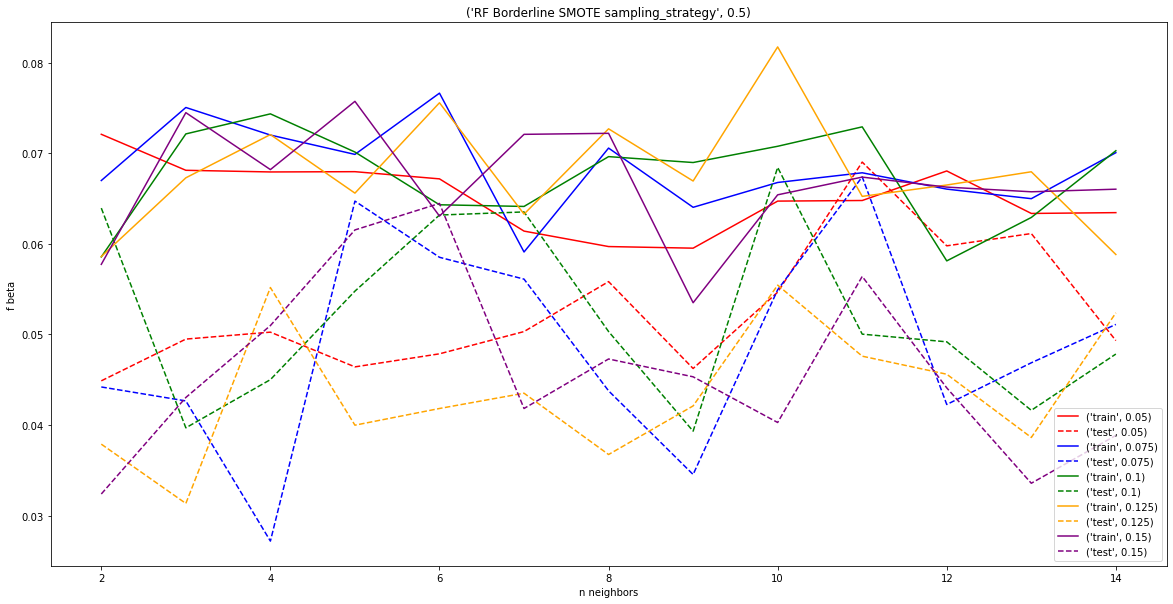

> ----------------- under= 0.6  ----------------
> ---------- over= 0.05  ---------
> ---------- over= 0.075  ---------
> ---------- over= 0.1  ---------
> ---------- over= 0.125  ---------
> ---------- over= 0.15  ---------


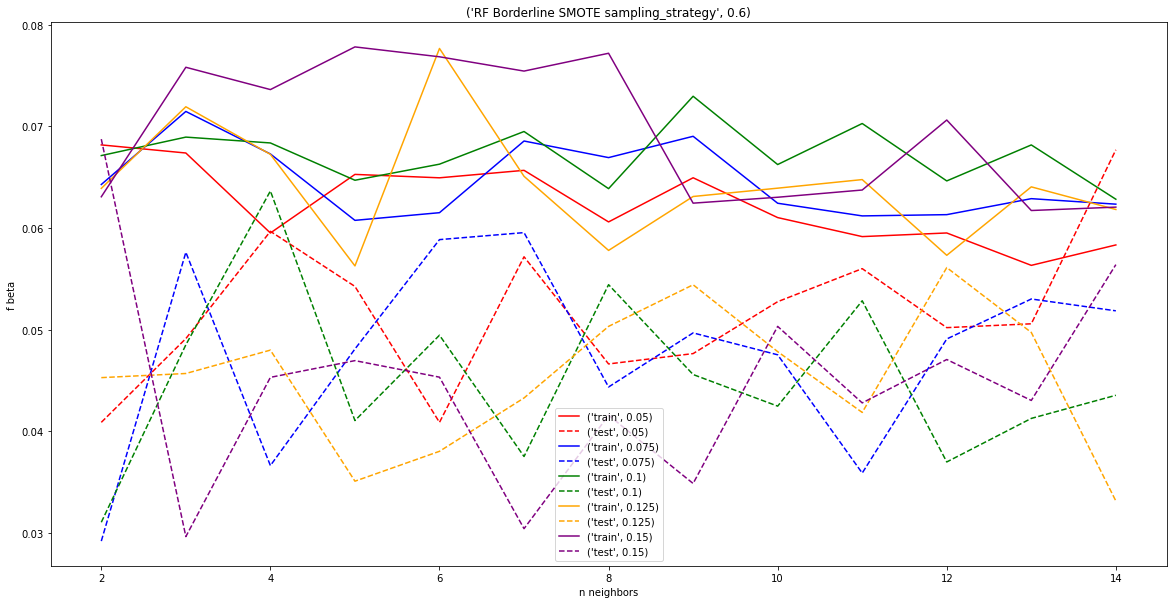

> ----------------- under= 0.7  ----------------
> ---------- over= 0.05  ---------
> ---------- over= 0.075  ---------


KeyboardInterrupt: 

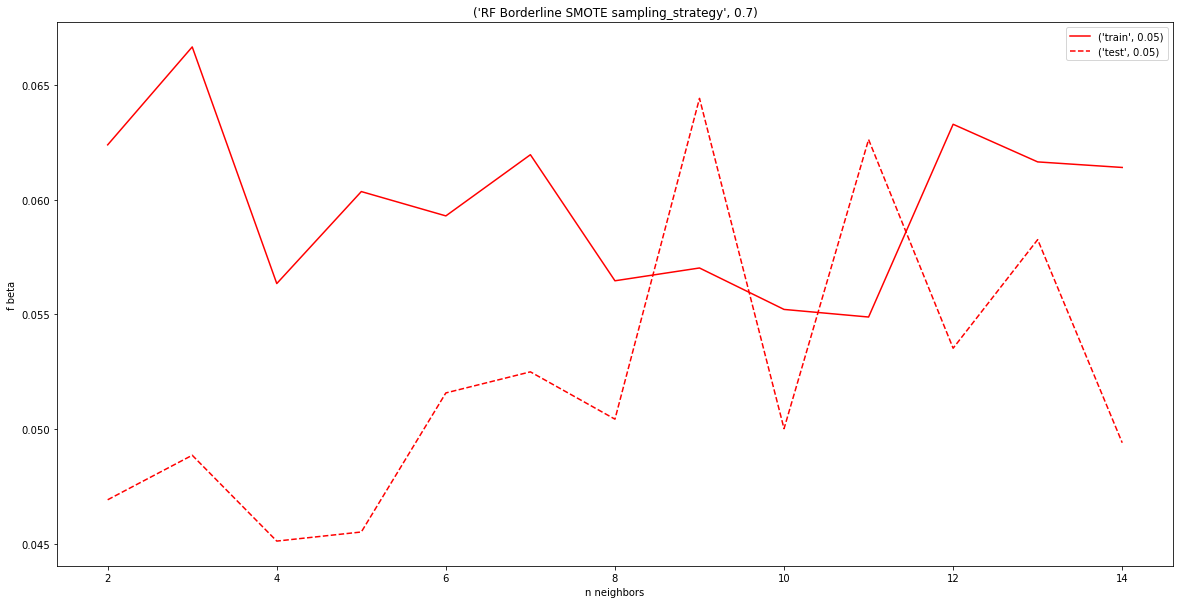

In [39]:
from sklearn.ensemble import RandomForestClassifier

unders = [0.5, 0.6]#
overs = [0.05, 0.075, 0.1, 0.125, 0.15]#06, 0.07, 0.08, 0.09, 

colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey']
lns = ['-','--',':']

#for i in range(3):
rf = RandomForestClassifier(bootstrap=False, 
                       max_depth=50,
                       max_features='sqrt',
                       min_samples_split=10, 
                       n_estimators=1200,
                       random_state=2)

# ckecking k, over, under values for SMOTE algo
for u, under in enumerate(unders):
    print('> ----------------- under=', under,' ----------------')

    plt.figure(figsize=(20,10))


    for o, over in enumerate(overs):
        fbs_train = []
        fbs_test = []
        print('> ---------- over=', over,' ---------' )

        for k in range(2,15):
            steps= [('over', BorderlineSMOTE(sampling_strategy=over, k_neighbors=k)), #
                    ('under', RandomUnderSampler(sampling_strategy=under)), 
                    ('model', rf)]
            pl = Pipeline(steps=steps)
            fb_train = model_cv1(pl, cv=xcv)

            m, pred, prob = classify(pl)
            fb_test = fbeta_score(y_test, pred, beta=0.3)

            fbs_train.append(fb_train)
            fbs_test.append(fb_test)
            #print('> k=%d, Mean train ROC AUC: %.3f, Test ROC AUC: %.3f' % (k, roc_train, roc_test))

        plt.title(('RF Borderline SMOTE sampling_strategy', under))

        plt.plot(range(2,15), np.array(fbs_train), c=colors[o], ls='-', label=('train', over))
        plt.plot(range(2,15), fbs_test, c=colors[o], ls='--', label=('test', over))
        plt.legend()
        plt.xlabel('n neighbors')
        plt.ylabel('f beta')

        #print('ROC train mean:', round(np.mean(rocs_train),3))
        #print('ROC test mean:', round(np.mean(rocs_test),3))
    plt.show()

# 
# OVER = 0.1, UNDER = 0.5, K=10 // 

> ----------------- under= 0.5  ----------------
> ---------- over= 0.075  ---------
> ---------- over= 0.1  ---------
> ---------- over= 0.125  ---------
> ---------- over= 0.15  ---------
> ---------- over= 0.2  ---------
> ---------- over= 0.25  ---------


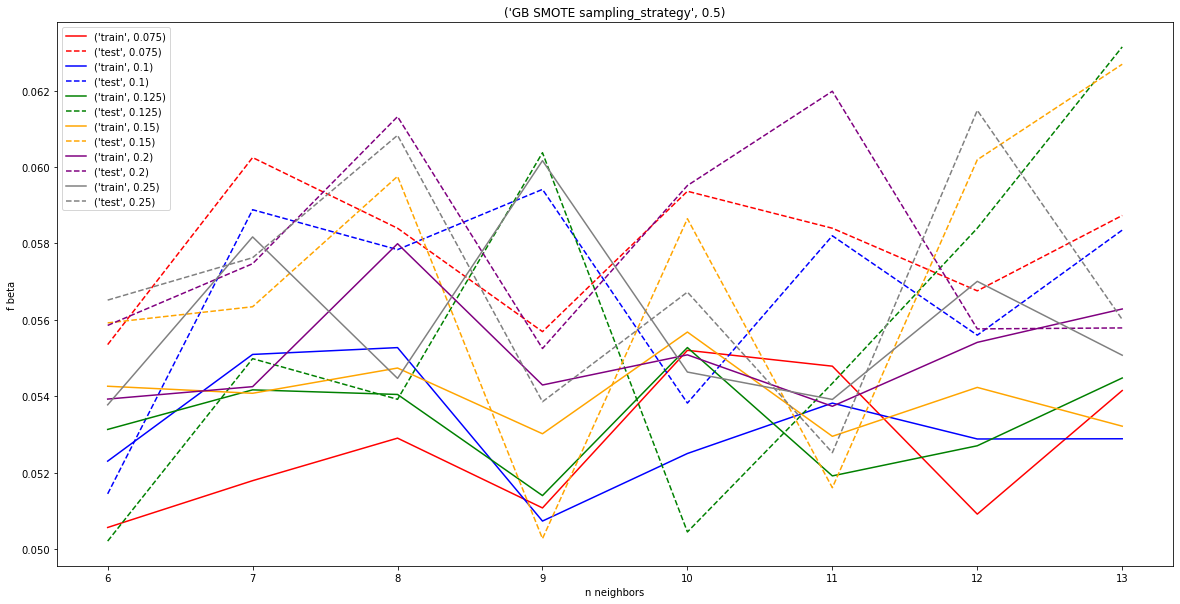

In [38]:
from sklearn.ensemble import RandomForestClassifier

unders = [0.5]#, 0.6, 0.7
overs = [0.075, 0.1, 0.125, 0.15, 0.2, 0.25]# 0.05

colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey']
lns = ['-','--',':']

#for i in range(3):
gb = GradientBoostingClassifier(learning_rate=0.025,
                            min_samples_split=0.6,
                            n_estimators=240,
                            random_state=2)

# ckecking k, over, under values for SMOTE algo
for u, under in enumerate(unders):
    print('> ----------------- under=', under,' ----------------')

    plt.figure(figsize=(20,10))


    for o, over in enumerate(overs):
        fbs_train = []
        fbs_test = []
        print('> ---------- over=', over,' ---------' )

        for k in range(6,14):
            steps= [('over', SMOTE(sampling_strategy=over, k_neighbors=k)), #
                    ('under', RandomUnderSampler(sampling_strategy=under)), 
                    ('model', gb)]
            pl = Pipeline(steps=steps)
            fb_train = model_cv1(pl, cv=xcv)

            m, pred, prob = classify(pl)
            fb_test = fbeta_score(y_test, pred, beta=0.3)

            fbs_train.append(fb_train)
            fbs_test.append(fb_test)
            #print('> k=%d, Mean train ROC AUC: %.3f, Test ROC AUC: %.3f' % (k, roc_train, roc_test))

        plt.title(('GB SMOTE sampling_strategy', under))

        plt.plot(range(6,14), np.array(fbs_train), c=colors[o], ls='-', label=('train', over))
        plt.plot(range(6,14), fbs_test, c=colors[o], ls='--', label=('test', over))
        plt.legend()
        plt.xlabel('n neighbors')
        plt.ylabel('f beta')

        #print('ROC train mean:', round(np.mean(rocs_train),3))
        #print('ROC test mean:', round(np.mean(rocs_test),3))
    plt.show()

# 
# OVER = 0.2, UNDER = 0.5, K=8 

## Evaluation

out of box log reg and rand for

out of box algos with resampling

tuned algos with resampling

In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

bor = BorderlineSMOTE(sampling_strategy=0.1) # 'over' in pipeline
smo = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

# f1 is f beta
gb_rocs = []
rf_rocs = []
rf_f1s = []
gb_f1s = []



gb_ = GradientBoostingClassifier(random_state=2)
gb_roc, gb_f1 = model_cv(gb_, cv=xcv)
gb_rocs.append(gb_roc)
gb_f1s.append(gb_f1)
gb0, gb0_pred, gb0_prob = classify(gb_)

steps_gb= [('over', smo), 
        ('under', under), 
        ('gb', gb_)]

pl = Pipeline(steps=steps_gb)
gb1_roc, gb1_f1 = model_cv(pl, cv=xcv)
gb_rocs.append(gb1_roc)
gb_f1s.append(gb1_f1)
gb1, gb1_pred, gb1_prob = classify(pl)

gb_ = GradientBoostingClassifier(learning_rate=0.025,
                            min_samples_split=0.6,
                            n_estimators=240,
                            random_state=2)

pl_gb2 = Pipeline(steps=steps_gb)
gb2_roc, gb2_f1 = model_cv(pl, cv=xcv)
gb_rocs.append(gb2_roc)
gb_f1s.append(gb2_f1)
gb2, gb2_pred, gb2_prob = classify(pl)


smo = SMOTE(sampling_strategy=0.2, k_neighbors=8)
gb_best_roc, gb_best_f1 = model_cv(pl, cv=xcv)
gb_rocs.append(gb_best_roc)
gb_f1s.append(gb_best_f1)
gb_best, gb_best_pred, gb_best_prob = classify(pl)



rf_ = RandomForestClassifier(random_state=2)
rf_roc, rf_f1 = model_cv(rf_, cv=xcv)
rf_rocs.append(rf_roc)
rf_f1s.append(rf_f1)
rf0, rf0_pred, rf0_prob = classify(rf_)

steps_rf= [('over', bor), 
        ('under', under), 
        ('rf', rf_)]

pl = Pipeline(steps=steps_rf)
rf1_roc, rf1_f1 = model_cv(pl, cv=xcv)
rf_rocs.append(rf1_roc)
rf_f1s.append(rf1_f1)
rf1, rf1_pred, rf1_prob = classify(pl)

rf_ = RandomForestClassifier(bootstrap=False, 
                       max_depth=50,
                       max_features='sqrt',
                       min_samples_split=10, 
                       n_estimators=1200,
                       random_state=2)

pl = Pipeline(steps=steps_rf)
rf2_roc, rf2_f1 = model_cv(pl, cv=xcv)
rf_rocs.append(rf2_roc)
rf_f1s.append(rf2_f1)
rf2, rf2_pred, rf2_prob = classify(pl)


bor = BorderlineSMOTE(sampling_strategy=0.1, k_neighbors=10)
rf_best_roc, rf_best_f1 = model_cv(pl, cv=xcv)
rf_rocs.append(rf_best_roc)
rf_f1s.append(rf_best_f1)
rf_best, rf_best_pred, rf_best_prob = classify(pl)


final_rocs = pd.DataFrame(list(zip(gb_rocs,
                                  rf_rocs)),
                         columns=['GradientBoostingSMOTE', 'Random Forest BorderlineSMOTE'],
                         index=['Out of Box', 'Basic Resampling', 
                                  'GridSearchCV', 'Tuned Resampling'])#, 'W/ Threshold'

final_f1s = pd.DataFrame(list(zip(gb_f1s,
                                  rf_f1s)),
                         columns=['GradeintBoostingSMOTE', 'Random Forest BorderlineSMOTE'],
                         index=['Out of Box', 'Basic Resampling', 
                                  'GridSearchCV', 'Tuned Resampling'])#, 'W/ Threshold'

In [8]:
final_rocs

,GradientBoostingSMOTE,Random Forest BorderlineSMOTE
Out of Box,0.769294,0.693012
Basic Resampling,0.776427,0.743368
GridSearchCV,0.774267,0.743312
Tuned Resampling,0.771622,0.743343


In [9]:
final_f1s

,GradeintBoostingSMOTE,Random Forest BorderlineSMOTE
Out of Box,0.011583,0.000000
Basic Resampling,0.049176,0.069340
GridSearchCV,0.049732,0.074608
Tuned Resampling,0.051425,0.067270


In [10]:
gb_best_thsh = find_threshold(gb_best_prob)

rf_best_thsh = find_threshold(rf_best_prob)

The threshold is 0.11827435229301322
The threshold is 0.05


Text(0.5, 1.0, 'GradientBoosting SMOTE Optimized w/ Threshold')

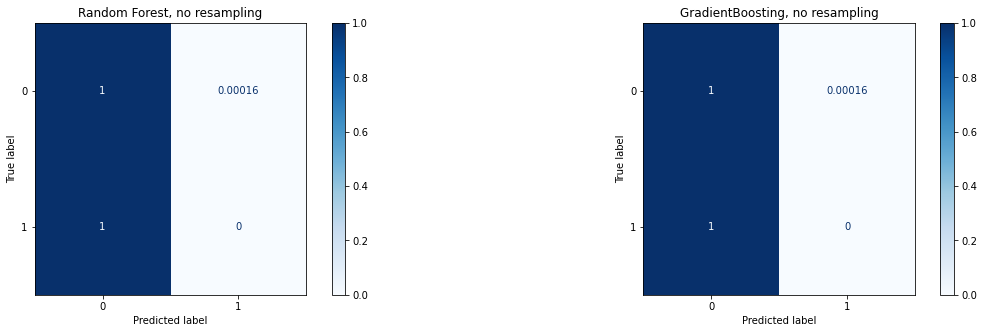

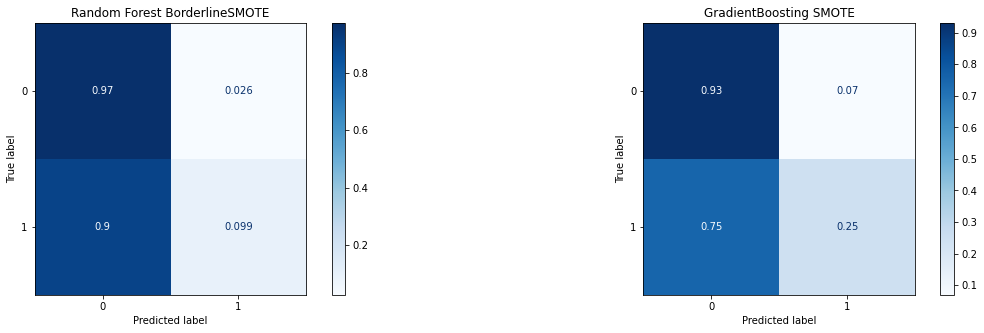

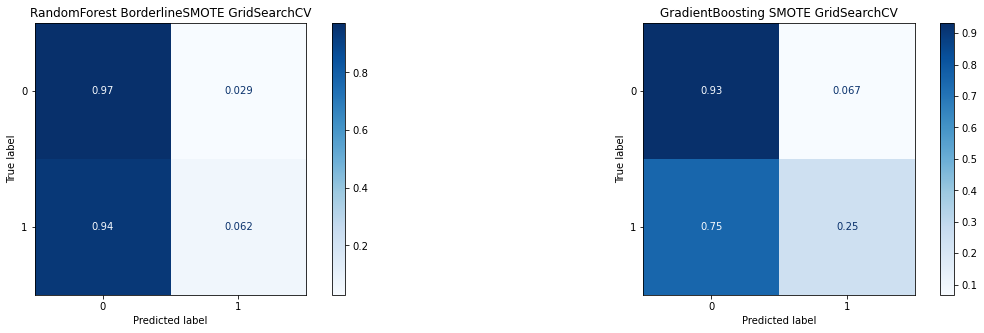

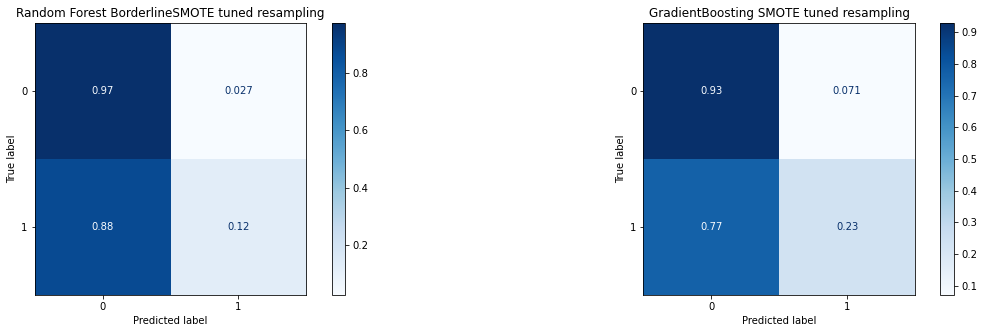

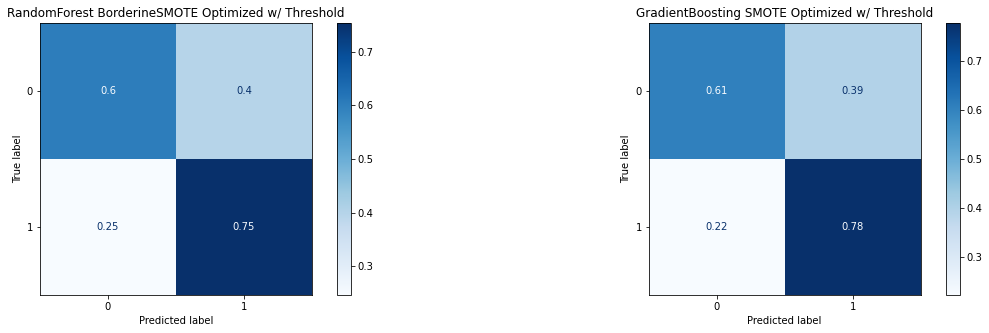

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
cm1 = confusion_matrix(y_test, rf0_pred, normalize='true')
cm2 = confusion_matrix(y_test, gb0_pred, normalize='true')
cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1, cmap=plt.cm.Blues)
cm2_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax2, cmap=plt.cm.Blues)
ax1.set_title('Random Forest, no resampling')
ax2.set_title('GradientBoosting, no resampling')

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,5))
cm3 = confusion_matrix(y_test, rf1_pred, normalize='true')
cm4 = confusion_matrix(y_test, gb1_pred, normalize='true')
cm3_dis = ConfusionMatrixDisplay(cm3).plot(ax=ax3, cmap=plt.cm.Blues)
cm4_dis = ConfusionMatrixDisplay(cm4).plot(ax=ax4, cmap=plt.cm.Blues)
ax3.set_title('Random Forest BorderlineSMOTE')
ax4.set_title('GradientBoosting SMOTE')

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(20,5))
cm5 = confusion_matrix(y_test, rf2_pred, normalize='true')
cm6 = confusion_matrix(y_test, gb2_pred, normalize='true')
cm5_dis = ConfusionMatrixDisplay(cm5).plot(ax=ax5, cmap=plt.cm.Blues)
cm6_dis = ConfusionMatrixDisplay(cm6).plot(ax=ax6, cmap=plt.cm.Blues)
ax5.set_title('RandomForest BorderlineSMOTE GridSearchCV')
ax6.set_title('GradientBoosting SMOTE GridSearchCV')

fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(20,5))
cm7 = confusion_matrix(y_test, rf_best_pred, normalize='true')
cm8 = confusion_matrix(y_test, gb_best_pred, normalize='true')
cm7_dis = ConfusionMatrixDisplay(cm7).plot(ax=ax7, cmap=plt.cm.Blues)
cm8_dis = ConfusionMatrixDisplay(cm8).plot(ax=ax8, cmap=plt.cm.Blues)
ax7.set_title('Random Forest BorderlineSMOTE tuned resampling')
ax8.set_title('GradientBoosting SMOTE tuned resampling')

fig, (ax7, ax8) = plt.subplots(1, 2, figsize=(20,5))
cm7 = confusion_matrix(y_test, rf_best_thsh, normalize='true')
cm8 = confusion_matrix(y_test, gb_best_thsh, normalize='true')
cm7_dis = ConfusionMatrixDisplay(cm7).plot(ax=ax7, cmap=plt.cm.Blues)
cm8_dis = ConfusionMatrixDisplay(cm8).plot(ax=ax8, cmap=plt.cm.Blues)
ax7.set_title('RandomForest BorderineSMOTE Optimized w/ Threshold')
ax8.set_title('GradientBoosting SMOTE Optimized w/ Threshold')
              
    

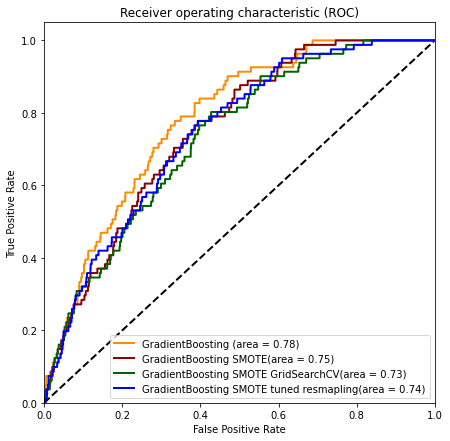

In [15]:
fig = plt.figure(figsize=(7,7))
lw = 2
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')

fpr, tpr, _ = roc_curve(y_test, gb0_prob)
auc = roc_auc_score(y_test, gb0_prob)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='GradientBoosting (area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, gb1_prob)
auc = roc_auc_score(y_test, gb1_prob)
plt.plot(fpr, tpr, color='darkred', lw=lw, label='GradientBoosting SMOTE(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, gb2_prob)
auc = roc_auc_score(y_test, gb2_prob)
plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='GradientBoosting SMOTE GridSearchCV(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, gb_best_prob)
auc = roc_auc_score(y_test, gb_best_prob)
plt.plot(fpr, tpr, color='blue', lw=lw, label='GradientBoosting SMOTE tuned resmapling(area = %0.2f)' % auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

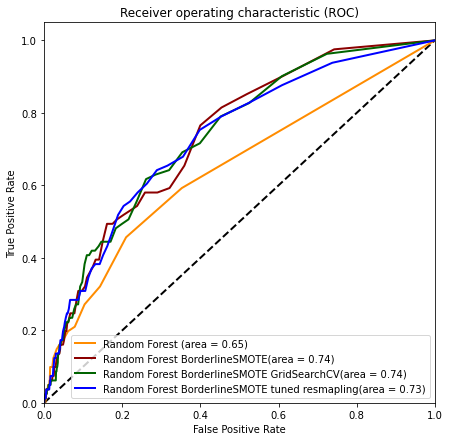

In [16]:
fig = plt.figure(figsize=(7,7))
lw = 2
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')

fpr, tpr, _ = roc_curve(y_test, rf0_prob)
auc = roc_auc_score(y_test, rf0_prob)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Random Forest (area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, rf1_prob)
auc = roc_auc_score(y_test, rf1_prob)
plt.plot(fpr, tpr, color='darkred', lw=lw, label='Random Forest BorderlineSMOTE(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, rf2_prob)
auc = roc_auc_score(y_test, rf2_prob)
plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='Random Forest BorderlineSMOTE GridSearchCV(area = %0.2f)' % auc)

fpr, tpr, _ = roc_curve(y_test, rf_best_prob)
auc = roc_auc_score(y_test, rf_best_prob)
plt.plot(fpr, tpr, color='blue', lw=lw, label='Random Forest BorderlineSMOTE tuned resmapling(area = %0.2f)' % auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ONE CLASS SVM: FIT TO ONLY NEGATIVE CLASS IN TRAINING VAUES, USE BOTH CLASSES FOR TEST.  NO RESAMPLING

# ISOLATED FOREST: NORMAL TEST AND FIT, NO RESAMPLING

### Isolated Forest

In [9]:
from sklearn.ensemble import IsolationForest

iso_ = IsolationForest(contamination=0.013, random_state=2)

iso = iso_.fit(X_train)

iso_pred = iso.predict(X_train)

In [10]:
temp = pd.DataFrame(data=iso_pred)

In [11]:
iso_pred_train = temp[0].map({1:0, -1:1})

In [12]:
fbeta_score(y_train, iso_pred_train, beta=0.3)

0.008171527100982083

In [35]:
print(classification_report(y_train, iso_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18603
           1       0.01      0.01      0.01       242

    accuracy                           0.97     18845
   macro avg       0.50      0.50      0.50     18845
weighted avg       0.97      0.97      0.97     18845



Text(0.5, 1.0, 'Isolation Forest')

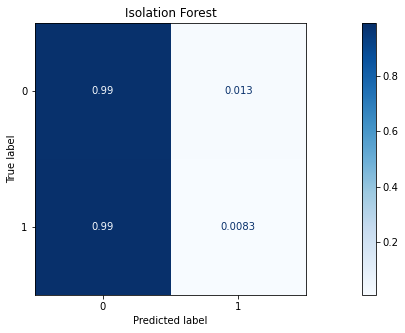

In [37]:
fig, (ax1) = plt.subplots(1, figsize=(20,5))
cm1 = confusion_matrix(y_train, iso_pred_train, normalize='true')

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1, cmap=plt.cm.Blues)

ax1.set_title('Isolation Forest')


### One Class SVM, novelty detection

- Combine x_train and y_train, x_test  and y_test
- strip train data of positive class
- fit train to estimator
- predict on test data
- remap results in same way as above
- score

In [15]:
train = pd.DataFrame(data=X_train)

train['y'] = y_train

In [22]:
train = train[train.y != 1]

In [23]:
test = pd.DataFrame(data=X_test)

test['y'] = y_test

In [30]:
from sklearn.svm import OneClassSVM

oc = OneClassSVM().fit(train)

oc_pred = oc.predict(test)


In [32]:
temp_oc = pd.DataFrame(data=oc_pred)

In [34]:
oc_pred = temp_oc[0].map({1:0, -1:1})

In [36]:
fbeta_score(y_test, oc_pred, beta=0.3)

0.021551710610145342

In [37]:
print(classification_report(y_test, oc_pred))

              precision    recall  f1-score   support

           0       0.99      0.50      0.66      6201
           1       0.02      0.78      0.04        81

    accuracy                           0.50      6282
   macro avg       0.51      0.64      0.35      6282
weighted avg       0.98      0.50      0.66      6282



Text(0.5, 1.0, 'One Class SVM')

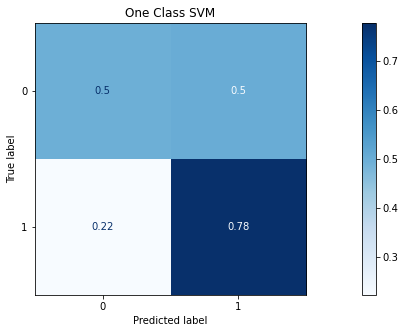

In [40]:
fig, (ax1) = plt.subplots(1, figsize=(20,5))
cm1 = confusion_matrix(y_test, oc_pred, normalize='true')

cm1_dis = ConfusionMatrixDisplay(cm1).plot(ax=ax1, cmap=plt.cm.Blues)

ax1.set_title('One Class SVM')
